In [1]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import timeit
from arch.bootstrap import CircularBlockBootstrap, optimal_block_length
import pickle
import numpy as np
import pandas as pdw
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from math import log
from scipy.stats import boxcox
from os import getenv, path
from pathlib import Path
from sys import getsizeof
import sys
import timeit

C:\Users\justi\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# dynamically deciding login info 
# then login to wrds
def pgpass_dir():
    if sys.platform.startswith('win'):
        os_path = getenv('LOCALAPPDATA')
        file_path = os_path+'\postgresql\pgpass.conf'
        print (file_path)
    elif sys.platform.startswith('darwin'):
        #* can be replaced by your laptop's name
        #in order to boost searching performance
        if path.exists('/Users/*/.pgpass'):
            file_path = '/Users/*/.pgpass'
        else:
            dir_path = os.path.dirname('/Users/')
            keyword = '.pgpass'
            for root, dirs, files in os.walk(dir_path):
                for file in files:
                    if keyword in file:
                        file_path = root+'/'+str(file)
    return file_path

In [4]:
file_path = pgpass_dir()
#read login info and pass connection parameters
with open(file_path,'r') as f:
    output = f.read()
    
    login_id = output.split(":")[3]
    crsp_db = wrds.Connection(wrds_username=login_id)

NameError: name 'sys' is not defined

In [ ]:
#combine login into one function
#in order to keep timeout away
#issue : too many connections to server 
# not in use
def re_conn_wrds():
    file_path = pgpass_dir()
    #read login info and pass connection parameters
    with open(file_path,'r') as f:
        output = f.read()
        login_id = output.split(":")[3]
        crsp_db = wrds.Connection(wrds_username=login_id)

In [ ]:
#retrieved cooresponding permno 
#criterion : the latest valid date
def data_generator(num=3, ticker_name=tuple(['GLD','SPY','TLT'])):
    ticker_list = {'tickers': tuple(ticker_name)}
    permno_list_init = crsp_db.raw_sql('SELECT a.permno FROM crsp.stocknames a, (SELECT distinct(max(nameenddt)) as date_time FROM crsp.stocknames WHERE ticker in %(tickers)s group by ticker) as b WHERE a.ticker in %(tickers)s and a.nameenddt = b.date_time group by a.permno', params=ticker_list)
    #generate tuple for permno
    permno_list_tuple = tuple(permno_list_init.permno.astype(str).values.tolist())
    permno_list = {'permno': permno_list_tuple}
    #generate data
    final_data = crsp_db.raw_sql('select distinct b.ticker, a.date, a.prc, a.ret from crspm.dsf a, crsp.stocknames b, \
    (select max(min_date) as start_time from (select distinct permno, min(date) over (partition by permno) as min_date from crspm.dsf where permno in %(permno)s) temp) as c \
where a.permno in %(permno)s and a.permno = b.permno and a.date >= c.start_time order by 1,2,3 asc', params=permno_list,date_cols=['date'])
    return final_data

In [ ]:
#generate dataframe and pickle file
def input_ticker():
    number_stock = int(input("Please enter your number of stocks, e.g 3,4,5: ").strip())
    ticker_name = []
    init_weight = []
    total_weight = 1
    temp_weight = 0
    [ticker_name.append(input("Please enter one ticker each time, e.g spy, tlt, gld: ").strip().upper()) for i in range(number_stock)]
    for i in ticker_name:
        temp_i = float(input("Please enter weight for {0}".format(i)))/10
        while temp_i > total_weight:
            temp_i = float(input("The percentage of {0} is greater than 100%, Please re-enter weight for {0}".format(i)))/10
        init_weight.append(temp_i)
        while sum(init_weight) > total_weight:
            init_weight.remove(temp_i)
            temp_i = float(input("Please re-enter weight for {0}, because of total amount is greather than 100%".format(i)))/10
            init_weight.append(temp_i)
    p_weight = dict(zip(ticker_name, init_weight))
    final_data = data_generator(number_stock,ticker_name)
    final_data_pivot = pd.pivot_table(final_data, index=['date'],columns='ticker').stack(level=-2).unstack(level=-1)
    final_data_pivot.to_pickle('dummy_data.pkl')
    return final_data_pivot, p_weight

In [ ]:
#new function for loading bulky tickers
def bulky_import(path_location):
    ticker_name = []
    init_weight = []
    total_weight = 1
    if path.exists(path_location):
        with open(path_location) as temp_file:
            for line in temp_file:
                ticker_1, number_1 = line.rstrip().split(',')
                ticker_name.append(ticker_1.upper())
                init_weight.append(number_1)
            weight = list(map(float,init_weight))
        if (sum(weight))/10 > total_weight:
            return (print ("The total percentage is greather than 100%, please check import file")),''
        else:
            p_weight = dict(zip(ticker_name,weight))
            final_data = data_generator(len(ticker_name), ticker_name)
            final_data_pivot = pd.pivot_table(final_data, index=['date'],columns='ticker').stack(level=-2).unstack(level=-1)
            final_data_pivot.to_pickle('dummy_data.pkl')
            return final_data_pivot, p_weight
    else:
        return (print("File do not exist!")),''

In [ ]:
final_data_pivot, p_weight = bulky_import(r'/Volumes/backup/MSCA31001 Reserch Desgin/Capstone_TDAmeritrade/all_tickers.txt')

In [ ]:
final_data_pivot

In [ ]:
p_weight

In [ ]:
final_data_pivot, p_weight = input_ticker()

In [ ]:
final_data_pivot

In [2]:
#with open('dummy_data.pkl', 'rb') as f: dummy_data = pickle.load(f)
with open('low_var_port.pkl', 'rb') as f: d = pickle.load(f)

In [3]:
dummy_data

NameError: name 'dummy_data' is not defined

In [4]:
d

ticker             SPY                                  TLT            \
metric             prc       ret      retx retd         prc       ret   
date                                                                    
2004-11-19  117.419998  0.988883  0.988883  0.0   88.260002  0.992020   
2004-11-22  117.980003  1.004769  1.004769  0.0   88.720001  1.005212   
2004-11-23  118.160004  1.001526  1.001526  0.0   88.830002  1.001240   
2004-11-24  118.440002  1.002370  1.002370  0.0   88.830002  1.000000   
2004-11-26  118.339996  0.999156  0.999156  0.0   88.250000  0.993471   
...                ...       ...       ...  ...         ...       ...   
2020-11-23  357.459991  1.005994  1.005994  0.0  160.770004  0.995418   
2020-11-24  363.220001  1.016114  1.016114  0.0  159.169998  0.990048   
2020-11-25  362.660004  0.998458  0.998458  0.0  158.679993  0.996921   
2020-11-27  363.670013  1.002785  1.002785  0.0  160.220001  1.009705   
2020-11-30  362.059998  0.995573  0.995573  0.0  160.020004  0.998752   

ticker                            GLD                           
metric          retx retd         prc       ret      retx retd  
date                                                            
2004-11-19  0.992020  0.0   44.779999  1.009013  1.009013  0.0  
2004-11-22  1.005212  0.0   44.950001  1.003796  1.003796  0.0  
2004-11-23  1.001240  0.0   44.750000  0.995551  0.995551  0.0  
2004-11-24  1.000000  0.0   45.049999  1.006704  1.006704  0.0  
2004-11-26  0.993471  0.0   45.290001  1.005327  1.005327  0.0  
...              ...  ...         ...       ...       ...  ...  
2020-11-23  0.995418  0.0  172.229996  0.980306  0.980306  0.0  
2020-11-24  0.990048  0.0  169.589996  0.984672  0.984672  0.0  
2020-11-25  0.996921  0.0  169.509995  0.999528  0.999528  0.0  
2020-11-27  1.009705  0.0  167.789993  0.989853  0.989853  0.0  
2020-11-30  0.998752  0.0  166.669998  0.993325  0.993325  0.0  

[4035 rows x 12 columns]

In [89]:
with open('low_var_port.pkl', 'rb') as f: data = pickle.load(f)
data = data.iloc[:,[1,5,9]]
data.iloc[0] = [1,1,1]
portfolio_weights = {'SPY':.5, 'TLT': .4, 'GLD': .1}
initial_money = 1000000
rebalance_days = 4500
threshold = .05

In [92]:
#Simulating the daily returns for each of the assets within the portfolio
def sim_returns(data, random_seed=None,block_size = 20, total_sim = 10):
    ret_index = [x for x, y in enumerate(data.columns) if y[1] == 'ret']
    ret_sim = data.iloc[:,ret_index].to_numpy()
    rs = np.random.RandomState(random_seed)
    ret_sim_mod = CircularBlockBootstrap(block_size, ret_sim, random_state = rs)
    col = ret_sim.shape[1]
    sim = np.zeros((total_sim,len(data), col))
    count = 0
    for y in ret_sim_mod.bootstrap(total_sim):
        sim[count,:,:] = y[0][0]
        count +=1
    return sim

In [13]:
sim_returns(d, random_seed=3,block_size = 20, total_sim = 10)

array([[[1.00757222, 0.98662334, 0.99885578],
        [1.02246838, 0.98001571, 1.00044551],
        [1.00060621, 1.00151935, 0.98276187],
        ...,
        [1.00228967, 1.01243724, 0.99636296],
        [1.01219984, 0.99504049, 0.98861466],
        [0.99126047, 1.00214707, 0.99920882]],

       [[1.00233613, 1.00386342, 1.00367975],
        [1.00004093, 0.99937165, 1.01588728],
        [1.00114486, 1.00322229, 0.9978346 ],
        ...,
        [1.01593934, 1.00888206, 0.99873315],
        [1.01161226, 1.00033862, 1.00245757],
        [0.98751349, 0.99856141, 0.98956109]],

       [[1.00554682, 0.99746886, 1.01105192],
        [0.9996214 , 1.00892854, 1.00170557],
        [1.00005415, 1.00530973, 0.99148668],
        ...,
        [1.02013188, 0.99399316, 1.01969484],
        [0.9999138 , 1.01256592, 1.00625996],
        [0.99879342, 0.99166354, 0.98907517]],

       ...,

       [[1.01327518, 0.9923347 , 1.00535816],
        [1.00362396, 1.00268212, 1.01022117],
        [1.01549783, 0

In [14]:
cum_ret={}
for k in range(3):
    cum_ret[k]=arr_data[:,k].cumprod()
cum_ret_1= pd.DataFrame(data=cum_ret)
cum_ret_1.columns = [str(col) + '_cum_ret' for col in cum_ret_1.columns]
num_rows, num_cols = arr_data.shape
ls_cum_ret_index = [x for x, y in enumerate(cum_ret_1)]
ls_cum_ret_index=[x+num_cols for x in ls_cum_ret_index]
cum_ret_2 = np.array(cum_ret_1)


NameError: name 'arr_data' is not defined

In [16]:
arr_data = np.array(d)
np.cumprod(arr_data, axis=0)

array([[1.        , 1.        , 1.        ],
       [1.00476925, 1.00521186, 1.00379638],
       [1.00630221, 1.00645819, 0.99933009],
       ...,
       [4.25379156, 3.05209899, 3.78539535],
       [4.26563839, 3.08171998, 3.74698532],
       [4.24675384, 3.07787318, 3.72197426]])

In [17]:
cum_ret_2.shape[1]

NameError: name 'cum_ret_2' is not defined

In [18]:
np.zeros(3)

array([0., 0., 0.])

In [42]:
def ret_rebalance(data,portfolio_weights, initial_money = 1000000, rebalance_days = 20, threshold = 10):
    
    arr_data = np.array(data)
    
    '''ls_tickers = []
    temp_tickers = list([y[0] for x, y in enumerate(arr_data_columns)])
    for i in temp_tickers:
        if i not in ls_tickers:
            ls_tickers.append(i)'''

    arr_port_det = np.zeros([data.shape[0], data.shape[1]*3]) #Need to change back to data
    arr_port_sum = np.zeros([data.shape[0], 1])
    arr_port_ret = np.zeros([data.shape[0], 1]) #Need to change back to data
    arr_portfolio_weights = np.array([i for i in portfolio_weights.values()])

    #This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
    #Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 

    arr_data = np.array(data)
    cum_ret_2 = np.cumprod(arr_data, axis=0)

    #Since the cum_ret_2 keeps track of the cumulative returns and when we rebalance, the cumulative return
    #needs to be reset to 1, so create an array to keep track the cumulative returns right before rebalancing,
    #and this will be used to reset the cumulative returns.

    cum_ret_tracking = np.zeros(data.shape[1])
    cum_ret_tracking[:]=1

    trading_day_counter=1
    count = 0
    initial_arr_asset_val = initial_money*arr_portfolio_weights
    num_assets = cum_ret_2.shape[1]
    
    for row in cum_ret_2:
        tradeflag = 0
        arr_rebal = np.zeros(num_assets)
        arr_latest_ret = row
        cur_asset_val = initial_arr_asset_val * arr_latest_ret/cum_ret_tracking
        total_value = np.sum(cur_asset_val)
        arr_actual_weights = cur_asset_val/total_value
        dev_weights = np.absolute((arr_actual_weights/arr_portfolio_weights)-1)

        if trading_day_counter % rebalance_days == 0 or np.amax(dev_weights) > threshold:

            tradeflag = 1
            cum_ret_tracking = arr_latest_ret

            arr_new_port_det = np.array([], dtype='f8')
          
            cur_asset_val = total_value*arr_portfolio_weights
      
            initial_arr_asset_val = cur_asset_val
            trading_day_counter=1
        else:
            trading_day_counter += 1    

        #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
        #total_value

        arr_new_port_det = np.array([], dtype='f8')
        ls_new_port_det = []
        for i in range(num_assets):

            ls_new_port_det = ls_new_port_det + [row[[i]], arr_actual_weights[i], cur_asset_val[i]]

        arr_port_det[count] = ls_new_port_det

        #arr_new_port_sum = [total_value, total_asset_value, arr_cash[-1].item(), arr_cash[-1].item()/(total_value)]
        arr_new_port_sum = [total_value]
        if count == 0:
            arr_port_ret[count] = 0
        else:
            arr_port_ret[count] = [(total_value/arr_port_sum[count-1])-1]
        arr_port_sum[count] = arr_new_port_sum
        tradeflag = 0
        count += 1
    return arr_port_sum, arr_port_det, arr_port_ret

In [43]:
ret_rebalance(d,portfolio_weights, initial_money = 1000000, rebalance_days = 2, threshold = 10)

(array([[1000000.        ],
        [1004849.00812153],
        [1005666.80142569],
        ...,
        [4279516.19698205],
        [4297725.37422102],
        [4283197.46789332]]),
 array([[1.00000000e+00, 5.00000000e-01, 5.00000000e+05, ...,
         1.00000000e+00, 1.00000000e-01, 1.00000000e+05],
        [1.00476925e+00, 4.99960313e-01, 5.02424504e+05, ...,
         1.00379638e+00, 9.98952454e-02, 1.00484901e+05],
        [1.00630221e+00, 5.00355630e-01, 5.03191046e+05, ...,
         9.99330085e-01, 9.94741028e-02, 1.00037803e+05],
        ...,
        [4.25379156e+00, 5.00254369e-01, 2.14084668e+06, ...,
         3.78539535e+00, 1.00158096e-01, 4.28628193e+05],
        [4.26563839e+00, 4.99522133e-01, 2.14886269e+06, ...,
         3.74698532e+00, 9.87217442e-02, 4.29772537e+05],
        [4.24675384e+00, 4.99474843e-01, 2.13934938e+06, ...,
         3.72197426e+00, 9.96694215e-02, 4.26903814e+05]]),
 array([[ 0.        ],
        [ 0.00484901],
        [ 0.00081385],
        ...,


## Evaluation code

In [98]:
total_sim = 100
sum_col = 1
det_col = 9
trading_days_per_year = 253
trade_days = 4035
years = trade_days/trading_days_per_year

arr_sum_value = np.zeros((total_sim,len(data), sum_col))
arr_ret_value = np.zeros((total_sim,len(data), sum_col))
arr_det_value = np.zeros((total_sim,len(data), det_col))
arr_ann_ret_nb = np.zeros((total_sim, 1))
arr_std_ret_nb = np.zeros((total_sim, 1))
counter = 0
ls_rebal_day = [1,21,63,126,253,400000]
ls_threshold = [.01,.05,.1,.2,.25,1000]
ls_performance = []
for d in ls_rebal_day:
    for t in ls_threshold:
        for x in range(total_sim):
            bootstrap = sim_returns(data,block_size = 20, total_sim = 1, random_seed = x)
            bootstrap[0][0] = [1,1,1]
            arr_port_sum, arr_port_det,arr_port_ret  = ret_rebalance(bootstrap[0],portfolio_weights, initial_money = 1, rebalance_days = d, threshold = t)
            arr_sum_value[x] = arr_port_sum
            arr_det_value[x] = arr_port_det
            arr_ret_value[x] = arr_port_ret
    
        counter +=1

        for x in range(total_sim):
            arr_ann_ret_nb[x] =  arr_sum_value[x][-1]**(1/years)-1
            arr_std_ret_nb[x] = np.std(arr_ret_value[x])*(trade_days_per_year**.5)
        ls_performance.append([d,t,np.mean(arr_ann_ret_nb),np.mean(arr_std_ret_nb)])

In [100]:
df_performance = pd.DataFrame(ls_performance, columns = ['rebal_days', 'threshold', 'ann_ret', 'daily_var'])

In [103]:
df_performance['ann_std'] = df_performance['daily_var']**(.5)*(253**(.5))

In [104]:
df_performance

rebal_days  threshold   ann_ret  daily_var   ann_std
0            1       0.01  0.096524   0.000036  0.094795
1            1       0.05  0.096524   0.000036  0.094795
2            1       0.10  0.096524   0.000036  0.094795
3            1       0.20  0.096524   0.000036  0.094795
4            1       0.25  0.096524   0.000036  0.094795
5            1    1000.00  0.096524   0.000036  0.094795
6           21       0.01  0.096583   0.000036  0.094781
7           21       0.05  0.095879   0.000035  0.094522
8           21       0.10  0.094226   0.000035  0.094292
9           21       0.20  0.093665   0.000034  0.093316
10          21       0.25  0.093558   0.000034  0.093207
11          21    1000.00  0.093534   0.000034  0.093196
12          63       0.01  0.096583   0.000036  0.094781
13          63       0.05  0.095911   0.000035  0.094549
14          63       0.10  0.094410   0.000035  0.094441
15          63       0.20  0.093708   0.000034  0.093399
16          63       0.25  0.093608   0.000034  0.093081
17          63    1000.00  0.093501   0.000034  0.092930
18         126       0.01  0.096583   0.000036  0.094781
19         126       0.05  0.095936   0.000035  0.094552
20         126       0.10  0.094443   0.000035  0.094496
21         126       0.20  0.094107   0.000035  0.093837
22         126       0.25  0.093894   0.000034  0.093408
23         126    1000.00  0.093665   0.000034  0.092944
24         253       0.01  0.096583   0.000036  0.094781
25         253       0.05  0.095934   0.000035  0.094552
26         253       0.10  0.094417   0.000035  0.094515
27         253       0.20  0.093886   0.000035  0.094239
28         253       0.25  0.093834   0.000035  0.094075
29         253    1000.00  0.093254   0.000035  0.093463
30      400000       0.01  0.096583   0.000036  0.094781
31      400000       0.05  0.095934   0.000035  0.094552
32      400000       0.10  0.094390   0.000035  0.094510
33      400000       0.20  0.093949   0.000035  0.094510
34      400000       0.25  0.094112   0.000036  0.094815
35      400000    1000.00  0.091860   0.000044  0.105933

## Month Rebalancing

In [76]:
total_sim = 100
sum_col = 1
det_col = 9
trading_days_per_year = 253
trade_days = 4035
years = trade_days/trading_days_per_year

arr_sum_value = np.zeros((total_sim,len(d), sum_col))
arr_ret_value = np.zeros((total_sim,len(d), sum_col))
arr_det_value = np.zeros((total_sim,len(d), det_col))
arr_ann_ret_mth = np.zeros((total_sim, 1))
arr_std_ret_mth = np.zeros((total_sim, 1))
counter = 0
for x in range(total_sim):
    bootstrap = sim_returns(d,block_size = 20, total_sim = 1, random_seed = x)
    bootstrap[0][0] = [1,1,1]
    arr_port_sum, arr_port_det,arr_port_ret  = ret_rebalance(bootstrap[0],portfolio_weights, initial_money = 1, rebalance_days = 21, threshold = 100)
    arr_sum_value[x] = arr_port_sum
    arr_det_value[x] = arr_port_det
    arr_ret_value[x] = arr_port_ret
    
    counter +=1

for x in range(total_sim):
    arr_ann_ret_mth[x] =  arr_sum_value[x][-1]**(1/years)-1
    arr_std_ret_mth[x] = np.std(arr_ret_value[x])**2

In [77]:
np.mean(arr_ann_ret_mth)

0.09353395519418099

In [83]:
np.mean(arr_std_ret_mth)

3.432999844480293e-05

In [57]:
trading_days_per_year = 253
years = test.shape[0]/trading_days_per_year
ann_ret = test[-1]**(1/years)-1

5.274906720179229

In [21]:
total_sim = 1000
col = 2
start_time1=timeit.default_timer()
for i in range(1000):
    x=sim_returns(d, block_size = 20, total_sim =1 , random_seed = 1)
end_time1 = timeit.default_timer()-start_time1
start_time2=timeit.default_timer()
bootstrap = sim_returns(d,block_size = 20, total_sim = total_sim, random_seed = 1)
end_time2 = timeit.default_timer()-start_time2
print(end_time1, end_time2)

1.5528817000000004 0.16431629999999586


In [18]:
from pympler import asizeof

In [19]:
asizeof.asizeof(bootstrap)

96840144

In [24]:
sys.maxsize

9223372036854775807

In [247]:
total_sim = 100
col = 2
bootstrap = sim_returns(d,block_size = 20, total_sim = total_sim, random_seed = 1)
#create the placeholder for arr_value that's in the same shape as the simulated return data
arr_value = np.zeros((total_sim,len(d), col))
arr_data_columns = d.columns.values
counter = 0
for x in bootstrap:
    x[0] = [1,1,1]
    portfolio_weights = {'SPY':.5, 'TLT': .4, 'GLD': .1}
    initial_money = 1000000
    rebalance_days = 1
    threshold = 10

    #Using the smulated data to perform rebalancing
    arr_data = x
    #Reset the index # tracking to be based on the simulated data
    ls_ret_index=list(range(len(arr_data[0])))
    ls_tickers = []
    #Re-arrange the data so the columns order matches the column order of the portfolio weigths
    temp_tickers = list([y[0] for x, y in enumerate(arr_data_columns)])
    for i in temp_tickers:
        if i not in ls_tickers:
            ls_tickers.append(i)

    #####delete the following lines as we don't seem to be using the initialize_df_continuous function anymore        
    #arr_port_det = np.zeros([d.shape[0], 9]) #Need to change back to data
    #arr_port_sum = np.zeros([d.shape[0], 2]) #Need to change back to data
    #arr_portfolio_weights = np.array([i for i in portfolio_weights.values()])
    #####Delete completed
    
    #This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
    #Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 
    cum_ret={}
    for k in range(len(ls_ret_index)):
        cum_ret[k]=arr_data[:,ls_ret_index[k]].cumprod()

    cum_ret_1= pd.DataFrame(data=cum_ret)
    cum_ret_1.columns = ls_tickers
    cum_ret_1.columns = [str(col) + '_cum_ret' for col in cum_ret_1.columns]
    num_rows, num_cols = arr_data.shape
    ls_cum_ret_index = [x for x, y in enumerate(cum_ret_1)]
    ls_cum_ret_index=[x+num_cols for x in ls_cum_ret_index]
    cum_ret_2 = np.array(cum_ret_1)

    #Since the cum_ret_2 keeps track of the cumulative returns and when we rebalance, the cumulative return
    #needs to be reset to 1, so create an array to keep track the cumulative returns right before rebalancing,
    #and this will be used to reset the cumulative returns.

    cum_ret_tracking = np.array(cum_ret_1.iloc[1])

    cum_ret_tracking[:]=1

    trading_day_counter=1
    count = 0
    initial_arr_asset_val = initial_money*arr_portfolio_weights

    for row in cum_ret_2:
        tradeflag = 0
        arr_rebal = np.zeros(len(ls_tickers))
        arr_latest_ret = row

        cur_asset_val = initial_arr_asset_val * arr_latest_ret/cum_ret_tracking
        total_value = np.sum(cur_asset_val)
        arr_actual_weights = cur_asset_val/total_value
        dev_weights = np.absolute((arr_actual_weights/arr_portfolio_weights)-1)

        if trading_day_counter % rebalance_days == 0 or np.amax(dev_weights) > threshold:

            tradeflag = 1
            cum_ret_tracking = arr_latest_ret

            arr_new_port_det = np.array([], dtype='f8')
          
            cur_asset_val = total_value*arr_portfolio_weights
      
            initial_arr_asset_val = cur_asset_val
            trading_day_counter=1
        else:
            trading_day_counter += 1    

        #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
        #total_value

        arr_new_port_det = np.array([], dtype='f8')
        ls_new_port_det = []
        ########Below is erroring out!!!!######
        for i in range(len(ls_tickers)):

            ls_new_port_det = ls_new_port_det + [row[ls_ret_index[i]], arr_actual_weights[i], cur_asset_val[i]]

        arr_port_det[count] = ls_new_port_det

        #arr_new_port_sum = [total_value, total_asset_value, arr_cash[-1].item(), arr_cash[-1].item()/(total_value)]
        arr_new_port_sum = [total_value]

        arr_port_sum[count] = arr_new_port_sum
        tradeflag = 0
        count += 1
    arr_value[counter] = arr_port_sum
    counter +=1
    

In [248]:
arr_value

array([[[1000000.        , 1000000.        ],
        [ 987927.49494314,  987927.49494314],
        [ 998243.42121614,  998243.42121614],
        ...,
        [2215169.96833631, 2215169.96833631],
        [2209869.55086891, 2209869.55086891],
        [2210728.63896946, 2210728.63896946]],

       [[1000000.        , 1000000.        ],
        [1006790.29081948, 1006790.29081948],
        [1007896.36866594, 1007896.36866594],
        ...,
        [5637194.26137184, 5637194.26137184],
        [5638294.77574348, 5638294.77574348],
        [5646151.39162742, 5646151.39162742]],

       [[1000000.        , 1000000.        ],
        [1002721.45556519, 1002721.45556519],
        [1003926.85586218, 1003926.85586218],
        ...,
        [4324647.64657581, 4324647.64657581],
        [4288511.69186387, 4288511.69186387],
        [4438208.04618975, 4438208.04618975]],

       ...,

       [[1000000.        , 1000000.        ],
        [ 994478.09220292,  994478.09220292],
        [1001529.62328

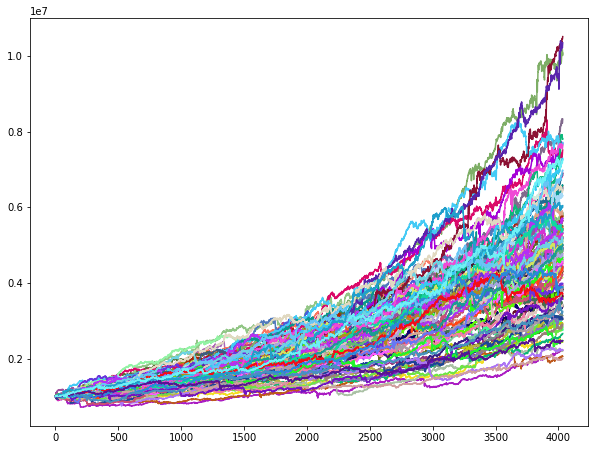

In [249]:
import random

b = list(range(4035))
a = [arr_value[i][:,0] for i in range(total_sim)]

rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr)

In [243]:

a = [arr_value[i][:,0] for i in range(total_sim)]
a

[array([1000000.        ,  987927.49494314,  998396.52904796, ...,
        2182831.62527276, 2177606.98962161, 2178419.56521579]),
 array([1000000.        , 1006790.29081948, 1007900.52671336, ...,
        5593658.43829496, 5595986.64511758, 5603394.5594043 ]),
 array([1000000.        , 1002721.45556519, 1003927.99309993, ...,
        4252052.47325222, 4216523.1103623 , 4363904.32570543]),
 array([1000000.        , 1000778.48120127,  998816.39306567, ...,
        3005903.26791685, 3003750.01563653, 3005921.78807413]),
 array([1000000.        ,  999192.32399552, 1003542.90086336, ...,
        5202241.07208625, 5201623.59234392, 5208272.90351613]),
 array([1000000.        , 1003642.63005322, 1000249.43981076, ...,
        4975915.79804171, 4961167.49948514, 4923584.55108385]),
 array([1000000.        , 1001518.92381291, 1011848.39197443, ...,
        5828403.45560697, 5804609.26919975, 5750466.96207652]),
 array([1000000.        , 1001447.45905563, 1002863.8375297 , ...,
        5369761.

In [208]:
arr_port_det = np.zeros([d.shape[0], 9]) #Need to change back to data
arr_port_sum = np.zeros([d.shape[0], 2]) #Need to change back to data
arr_portfolio_weights = np.array([i for i in portfolio_weights.values()])

#This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
#Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 
cum_ret={}
for k in range(len(ls_ret_index)):
    cum_ret[k]=d[:,ls_ret_index[k]].cumprod()

cum_ret_1= pd.DataFrame(data=cum_ret)
cum_ret_1.columns = ls_tickers
cum_ret_1.columns = [str(col) + '_cum_ret' for col in cum_ret_1.columns]
num_rows, num_cols = arr_data.shape
ls_cum_ret_index = [x for x, y in enumerate(cum_ret_1)]
ls_cum_ret_index=[x+num_cols for x in ls_cum_ret_index]
cum_ret_2 = np.array(cum_ret_1)

#Since the cum_ret_2 keeps track of the cumulative returns and when we rebalance, the cumulative return
#needs to be reset to 1, so create an array to keep track the cumulative returns right before rebalancing,
#and this will be used to reset the cumulative returns.

cum_ret_tracking = np.array(cum_ret_1.iloc[1])

cum_ret_tracking[:]=1

trading_day_counter=1
count = 0
initial_arr_asset_val = initial_money*arr_portfolio_weights

for row in cum_ret_2:
    tradeflag = 0
    arr_rebal = np.zeros(len(ls_tickers))
    arr_latest_ret = row

    cur_asset_val = initial_arr_asset_val * arr_latest_ret/cum_ret_tracking
    total_value = np.sum(cur_asset_val)
    arr_actual_weights = cur_asset_val/total_value
    dev_weights = np.absolute((arr_actual_weights/arr_portfolio_weights)-1)

    if trading_day_counter % rebalance_days == 0 or np.amax(dev_weights) > threshold:

        tradeflag = 1
        cum_ret_tracking = arr_latest_ret

        arr_new_port_det = np.array([], dtype='f8')
        print(trading_day_counter)
        cur_asset_val = total_value*arr_portfolio_weights
        print(cur_asset_val)
        initial_arr_asset_val = cur_asset_val
        trading_day_counter=1
    else:
        trading_day_counter += 1    

    #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"
    #total_value

    arr_new_port_det = np.array([], dtype='f8')
    ls_new_port_det = []
    for i in range(len(ls_tickers)):

        ls_new_port_det = ls_new_port_det + [row[ls_ret_index[i]], arr_actual_weights[i], cur_asset_val[i]]

    arr_port_det[count] = ls_new_port_det

    #arr_new_port_sum = [total_value, total_asset_value, arr_cash[-1].item(), arr_cash[-1].item()/(total_value)]
    arr_new_port_sum = [total_value]

    arr_port_sum[count] = arr_new_port_sum
    tradeflag = 0
    count += 1

4
[497919.74442459 398335.79553967  99583.94888492]
3
[485174.80699814 388139.84559851  97034.96139963]
8
[454195.45612458 363356.36489967  90839.09122492]
48
[481884.45383762 385507.5630701   96376.89076752]
27
[474551.64579325 379641.3166346   94910.32915865]
1
[461244.76284888 368995.81027911  92248.95256978]
1
[462747.99415227 370198.39532181  92549.59883045]
2
[422700.4211579  338160.33692632  84540.08423158]
1
[435656.30003989 348525.04003191  87131.26000798]
1
[422608.27210384 338086.61768307  84521.65442077]
1
[423317.57260196 338654.05808157  84663.51452039]
3
[410522.11964095 328417.69571276  82104.42392819]
2
[408802.55382532 327042.04306026  81760.51076506]
9
[404844.05172486 323875.24137989  80968.81034497]
8
[406472.1756398  325177.74051184  81294.43512796]
43
[406735.24528016 325388.19622412  81347.04905603]
19
[412432.27979971 329945.82383976  82486.45595994]
2
[411448.43474194 329158.74779356  82289.68694839]
2
[418613.88550726 334891.10840581  83722.77710145]
6
[40472

In [178]:
 df_portfolio_sum = pd.DataFrame(arr_port_sum, index = d.index)

In [106]:
 df_portfolio_detail = pd.DataFrame(arr_port_det, index = d.index)

In [162]:
df_portfolio_detail.head(50)

Empty DataFrame
Columns: [(SPY, price), (SPY, return), (SPY, weight), (SPY, shares), (SPY, value), (TLT, price), (TLT, return), (TLT, weight), (TLT, shares), (TLT, value), (GLD, price), (GLD, return), (GLD, weight), (GLD, shares), (GLD, value)]
Index: []

In [98]:
cum_ret_1

SPY_cum_ret  TLT_cum_ret  GLD_cum_ret
0        0.988883     0.992020     1.009013
1        0.993600     0.997190     1.012844
2        0.995115     0.998426     1.008337
3        0.997474     0.998426     1.015097
4        0.996631     0.991907     1.020505
...           ...          ...          ...
4030     4.146188     3.067622     3.880802
4031     4.212999     3.037092     3.821316
4032     4.206503     3.027743     3.819513
4033     4.218218     3.057127     3.780757
4034     4.199544     3.053311     3.755520

[4035 rows x 3 columns]